## Notebook to compare PyTorch and OpenVINO output
Following are the steps:

1. Import packages and setup paths
1. Get Mask
1. Load PyTorch Model
1. Run PyTorch Inference
1. Convert PyTorch model to OpenVINO model
1. Load OpenVINO Model
1. Run OpenVINO Inference
1. Plot Outputs and compare outputs

In [1]:
import os
import sys
import torch
import numpy as np
from BrainMaGe.models.networks import fetch_model
from pathlib import Path
import matplotlib.pyplot as plt
from compare_utils import (
    postprocess_prediction,
    postprocess_save_output,
    dice,
    get_mask_image,
    get_input_image
)
from timeit import default_timer as timer
from datetime import timedelta

In [20]:
brainmage_root = Path('../')

input_path = '../compare_onnx/sub-A00028185_ses-NFB3_T1w_brain.nii.gz'
mask_path= '../compare_onnx/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz'
pt_output_path = 'pt-outfile' # PyTorch output file
ov_output_path = 'ov-outfile' # ONNX output file

pytorch_model_path = brainmage_root / 'BrainMaGe/weights/resunet_ma.pt'
ov_model_dir = brainmage_root / 'BrainMaGe/weights/ov/fp32/'

device="cpu"


### Get Mask

In [3]:
mask_image = get_mask_image(mask_path)
print(f"mask_image Image size: {mask_image.shape} , dtype: {mask_image.dtype} ")

mask_image Image size: (256, 256, 192) , dtype: float32 


### Load PyTorch model

In [4]:
pt_model = fetch_model(modelname="resunet", num_channels=1, num_classes=2, num_filters=16)
checkpoint = torch.load(pytorch_model_path, map_location=torch.device('cpu'))
pt_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Run PyTorch Inference

In [5]:
_ = pt_model.eval()

input_image, patient_nib = get_input_image(input_path)
print(f"patient_nib Image size: {patient_nib.shape} ")
print(f"Input Image size: {input_image.shape} , dtype: {input_image.dtype} ")

with torch.no_grad():
    start = timer()
    pt_output = pt_model(input_image)
    end = timer()
    print(f"PyTorch Inference time: {end-start:.3f} seconds")
    
    pt_output = pt_output.cpu().numpy()[0][0]
    print(f"Output Image size: {pt_output.shape} , dtype: {pt_output.dtype} ")
    
    pt_to_save, pt_save_nib = postprocess_save_output(pt_output, patient_nib, pt_output_path)



patient_nib Image size: (256, 256, 192) 
Input Image size: torch.Size([1, 1, 128, 128, 128]) , dtype: torch.float32 
PyTorch Inference time: 8.417 seconds
Output Image size: (128, 128, 128) , dtype: float32 
to_save Image size: (256, 256, 192) , dtype: float32 
Output saved at:  pt-outfile


In [6]:
pt_dice_score = dice(pt_to_save, mask_image)
print("PyTorch model Dice Score: ", pt_dice_score)

PyTorch model Dice Score:  1.0


In [7]:

pt_dice_score = dice(pt_to_save, mask_image)
print("PyTorch model Dice Score: ", pt_dice_score)

PyTorch model Dice Score:  1.0


### Convert PyTorch model to OpenVINO IR

In [13]:
!python export-to-ov.py

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	resunet(
  (ins): in_conv(
    (dropout): Dropout3d(p=0.3, inplace=False)
    (in_0): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (in_1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (ds_0): DownsamplingModule(
    (in_0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  )
  (en_1): EncodingModule(
    (dropout): Dropout3d(p=0.3, inplace=False)
    (in_0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (in_1

In [18]:
print(ov_model_dir)
!ls -l $ov_model_dir

../BrainMaGe/weights/ov/fp32
total 32540
-rw-rw-r-- 1 sdp sdp 33152004 Jul  8 14:28 resunet_ma.bin
-rw-rw-r-- 1 sdp sdp    16759 Jul  8 14:28 resunet_ma.mapping
-rw-rw-r-- 1 sdp sdp   145170 Jul  8 14:28 resunet_ma.xml


#### Load OpenVINO model

In [21]:
ov_model_name = "resunet_ma" 

In [22]:
from openvino.inference_engine import IECore

model_xml = f'{ov_model_dir}/{ov_model_name}.xml'
model_bin = f'{ov_model_dir}/{ov_model_name}.bin'

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))



In [23]:
input_layer

'input'

#### Run OpenVINO Inference

In [15]:
input_image, patient_nib = get_input_image(input_path)

#Run the Inference on the Input image...
start = timer()
ov_output = exec_net.infer(inputs={input_layer: input_image})
end = timer()
print(f"OpenVINO Inference time: {end-start:.3f} seconds")

ov_output = ov_output[output_layer][0][0]

OpenVINO Inference time: 0.204 seconds


In [16]:
print(f"ov_output size: {ov_output.shape} , dtype: {ov_output.dtype} ")

ov_output size: (128, 128, 128) , dtype: float32 


In [17]:
ov_to_save, ov_to_save_nib = postprocess_save_output(ov_output, patient_nib, ov_output_path)

to_save Image size: (256, 256, 192) , dtype: float32 
Output saved at:  ov-outfile


In [19]:
ov_dice_score = dice(ov_to_save, mask_image)
print("OV Dice Score: ", ov_dice_score)

OV Dice Score:  1.0


### PyTorch Dice vs ONNX Dice

In [20]:
print("PyTorch Dice Score: ", pt_dice_score)
print("ONNX Dice Score: ", ov_dice_score)

PyTorch Dice Score:  1.0
ONNX Dice Score:  1.0


### Plot Outputs

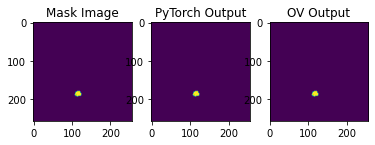

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask_image[:,:,100])
ax1.set_title('Mask Image')

ax2.imshow(pt_to_save[:,:,100])
ax2.set_title('PyTorch Output')

ax3.imshow(ov_to_save[:,:,100])
_ = ax3.set_title('OV Output')

In [23]:
from collections import Counter

mask_counts = Counter(mask_image.flatten())
pt_counts = Counter(pt_to_save.flatten())
ov_counts = Counter(ov_to_save.flatten())
print("mask_counts:", mask_counts)
print("pt_counts:", pt_counts)
print("ort_counts:", ov_counts)

mask_counts: Counter({0.0: 12579475, 1.0: 3437})
pt_counts: Counter({0.0: 12579475, 1.0: 3437})
ort_counts: Counter({0.0: 12579475, 1.0: 3437})
